# Openness and Forsmark stress state

In this notebook, the openness is evaluated as a function of Forsmark stress state. <br>
Fracture normal an shear stresses are calculated from the site model available in Martin (2007). <br>

### Python packages and functions

In [7]:
import sys, os, math, numpy as np
import pandas as pd
import matplotlib.pyplot as plt

path=r'python_functions'
sys.path.append(path)
import utils_stress as uS #functions to calculate stresses
import utils_fop as uF #functions to calculate openness

In [8]:
#ignore python warnings in the notebook
import warnings
warnings.filterwarnings('ignore')

### Retrieve Forsmark fracture dataset

In [9]:
input_folder = r'input_data'
filename = 'p_frac_core_select'
all_data = pd.read_csv(os.path.join(input_folder,filename+str('.txt')), sep = ';')

### Forsmark stress field data (from Martin (2007) (R-07-27))

In [10]:
surface_level = 0 #Hypothesis : Forsmark altitude is at zero sea level. (It is in reality very close)

sigma_H_depth = [[0,150,0.008,19], [150,400,0.074,9.1], [400,1000,0.023,29.5]] # different levels : [depth_up,depth_low, grad, origin]
sigma_H_ori = [145, 0] #trend, plunge

sigma_h_depth = [[0,150,0.006,11], [150,400,0.034,6.8], [400,1000,0.028,9.2]]
sigma_h_ori = [55, 0]

sigma_V_depth = [[0,1000,0.0265,0]] 
sigma_V_ori = [0,90] 

<div>
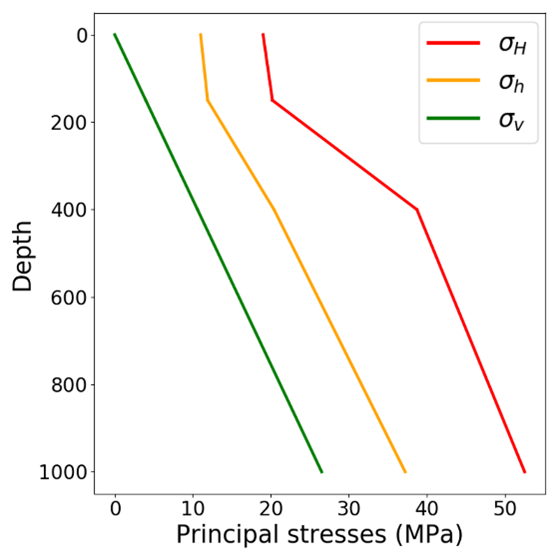
</div>

## 1) Compute each fracture stresses (normal and shear)

In [11]:
#empty fracture lists
frac_sigma_V_list = []
frac_sigma_H_list = []
frac_sigma_h_list = []
frac_sigma_n_list = []
frac_sigma_t_list = []

#loop over each fractures
for index, row in all_data.iterrows():
    dip = row['DIP(degrees)']
    strike = row['STRIKE(degrees)']
    dipd = (strike + 90) % 360
    depth = surface_level-row['ELEVATION_ADJUSTEDSECUP'] #fracture depth

    # calculate and store principal stress components calculated at fracture depth
    for depth_tranche in sigma_H_depth:
        if (depth>depth_tranche[0] and depth<depth_tranche[1]):
            frac_sigma_H = depth_tranche[2]*depth+depth_tranche[3]
    for depth_tranche in sigma_h_depth:
        if (depth>depth_tranche[0] and depth<depth_tranche[1]):
            frac_sigma_h = depth_tranche[2]*depth+depth_tranche[3]
    for depth_tranche in sigma_V_depth:
        if (depth>depth_tranche[0] and depth<depth_tranche[1]):
            frac_sigma_V = depth_tranche[2]*depth+depth_tranche[3]
            
    frac_sigma_V = -frac_sigma_V #convention for compressional stress
    frac_sigma_H = -frac_sigma_H
    frac_sigma_h = -frac_sigma_h
    frac_sigma_V_list.append(frac_sigma_V)
    frac_sigma_H_list.append(frac_sigma_H)
    frac_sigma_h_list.append(frac_sigma_h)

    # calculate and store normal and shear stress
    stress_tensor = uS.stress_tensor(frac_sigma_H,sigma_H_ori[0],sigma_H_ori[1], frac_sigma_h,sigma_h_ori[0],sigma_h_ori[1], frac_sigma_V,sigma_V_ori[0],sigma_V_ori[1])
    normale = uS.get_fracture_normale(dip,dipd)
    force = stress_tensor.dot(normale)
    frac_sigma_n = np.dot(force, normale)
    frac_sigma_t = np.linalg.norm(np.cross(normale,(np.cross(force, normale))))
    frac_sigma_n_list.append(-frac_sigma_n) #compressive stress is set to positive values
    frac_sigma_t_list.append(frac_sigma_t)
    
# add stress information to the dataset and save it
all_data['norm_stress'] = frac_sigma_n_list 
all_data['tan_stress'] = frac_sigma_t_list
all_data['V_stress'] = frac_sigma_V_list
all_data['H_stress'] = frac_sigma_H_list
all_data['h_stress'] = frac_sigma_h_list
dF = all_data
dF.to_csv(os.path.join(input_folder,filename+str('_with_stresses.txt')), sep = '\t', index = True)  

## 2) Fractures number and openness in a normal/shear stress diagram

### Mohr Coulomb failure envelop data (from Glamheden et al. (2007) (R-07-27))

In [12]:
# from sealed fractures tests
_mu_s = 1.33   #friction coefficient
_c_s = 4       # cohesion (MPa)

# from open fractures tests
_mu_o = 0.73
_c_o = 0.7

### Open and sealed fracture number in 2D bins of normal and shear stress

We use the function 'histogram2d' available in numpy.

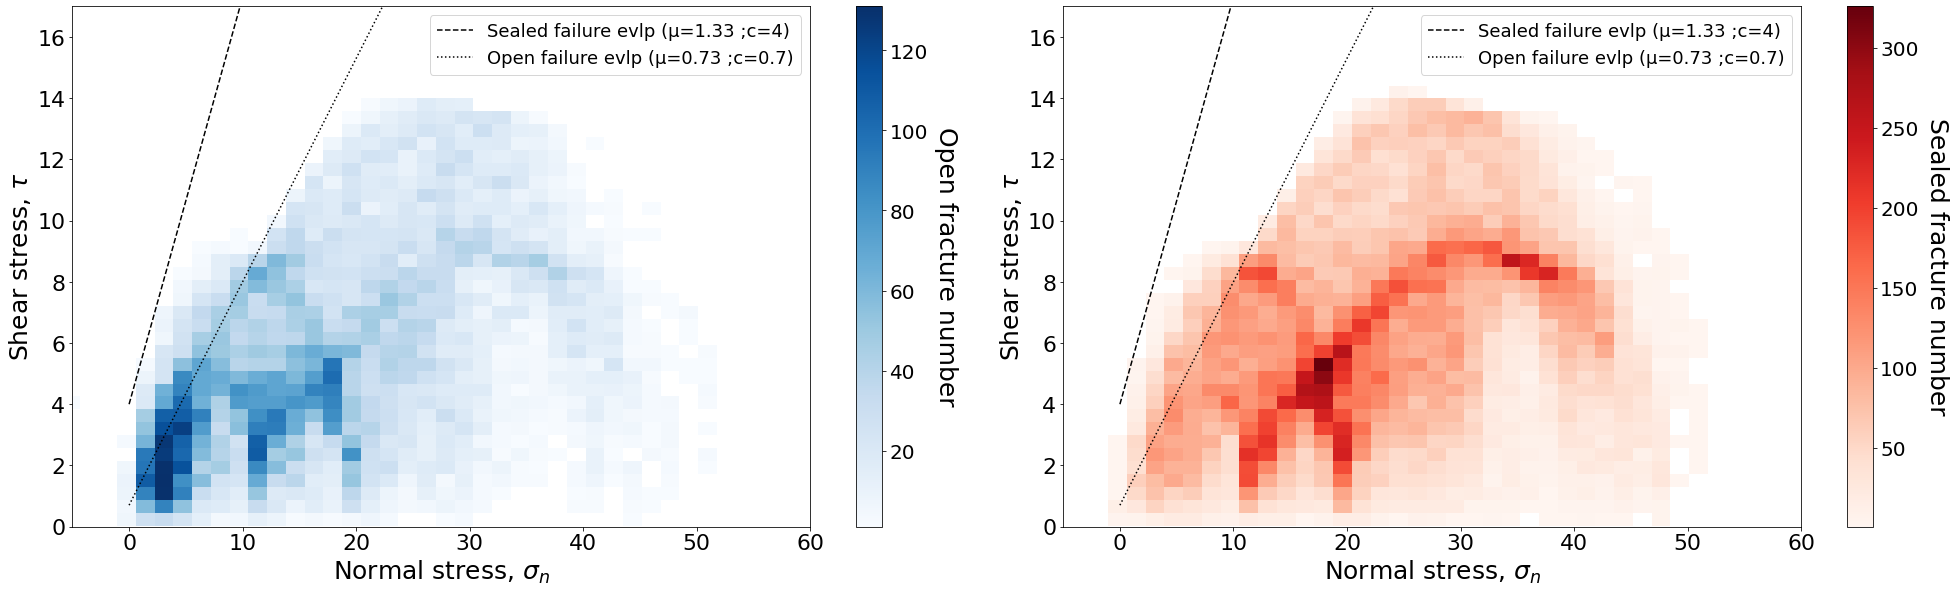

In [13]:
#---prepare bins
bin_norm_stress = np.linspace(all_data['norm_stress'].min(), all_data['norm_stress'].max(), num = 50, endpoint = True)
bin_shear_stress = np.linspace(all_data['tan_stress'].min(), all_data['tan_stress'].max(), num = 50, endpoint = True)

#---select open and sealed data
data_select_open = all_data.loc[all_data['FRACT_INTERPRET'].isin(['Open','Partly open'])]
data_select_sealed = all_data.loc[all_data['FRACT_INTERPRET'].isin(['Sealed'])]

#---open fracture number
norm_stress = data_select_open['norm_stress'].values
tan_stress = data_select_open['tan_stress'].values
h_open, xedges, yedges = np.histogram2d(norm_stress, tan_stress, bins=(bin_norm_stress, bin_shear_stress))
h_open[h_open == 0] = np.nan

#---sealed fracture number
norm_stress = data_select_sealed['norm_stress'].values
tan_stress = data_select_sealed['tan_stress'].values
h_sealed, xedges, yedges = np.histogram2d(norm_stress, tan_stress, bins=(bin_norm_stress, bin_shear_stress))
h_sealed[h_sealed == 0] = np.nan

#---plots
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(1,2,1)
ax.set_xlabel('Normal stress, $\sigma_n$', fontsize = 25) #and \u03C4 
ax.set_ylabel('Shear stress, $\u03C4$', fontsize = 25)
ax.tick_params(axis="x", labelsize=22)
ax.tick_params(axis="y", labelsize=22)
pc = ax.pcolorfast(xedges, yedges, h_open.T, cmap=plt.cm.Blues)
colorbar = fig.colorbar(pc)
colorbar.set_label('Open fracture number', rotation = 270, fontsize = 25, labelpad=30)
colorbar.ax.tick_params(labelsize=20)

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlabel('Normal stress, $\sigma_n$', fontsize = 25) #and \u03C4 
ax2.set_ylabel('Shear stress, $\u03C4$', fontsize = 25)
ax2.tick_params(axis="x", labelsize=22)
ax2.tick_params(axis="y", labelsize=22)
pc = ax2.pcolorfast(xedges, yedges, h_sealed.T, cmap=plt.cm.Reds)
colorbar = fig.colorbar(pc)
colorbar.set_label('Sealed fracture number', rotation = 270, fontsize = 25, labelpad=30)
colorbar.ax.tick_params(labelsize=20)

#---plot failure envelops
x = np.linspace(0,60,1000)
y_s = x*_mu_s+_c_s
y_o = x*_mu_o+_c_o
ax.plot(x,y_s, 'k--', label = 'Sealed failure evlp (\u03BC='+str(_mu_s)+' ;c='+str(_c_s)+')')
ax.plot(x,y_o, 'k:', label = 'Open failure evlp (\u03BC='+str(_mu_o)+' ;c='+str(_c_o)+')')
ax2.plot(x,y_s, 'k--', label = 'Sealed failure evlp (\u03BC='+str(_mu_s)+' ;c='+str(_c_s)+')')
ax2.plot(x,y_o, 'k:', label = 'Open failure evlp (\u03BC='+str(_mu_o)+' ;c='+str(_c_o)+')')

ax.legend(fontsize = 18, loc = 'upper right')
ax.set_xlim(-5, 60)
ax.set_ylim(0, 17)
ax2.legend(fontsize = 18, loc = 'upper right')
ax2.set_xlim(-5, 60)
ax2.set_ylim(0, 17)

fig.set_tight_layout(True)
fig.set_size_inches(2000./fig.dpi,600./fig.dpi)
plt.show()

### Openness calculated in 2D bins of normal and shear stress

We use the function 'fop2D' (see folder 'python_function' and file 'utils_fop').

In [14]:
h, norm_stress_bin, tan_stress_bin = uF.fop2D(all_data, 'norm_stress','tan_stress', min1=-10, max1 = 60, min2 = -5, max2 = 17)

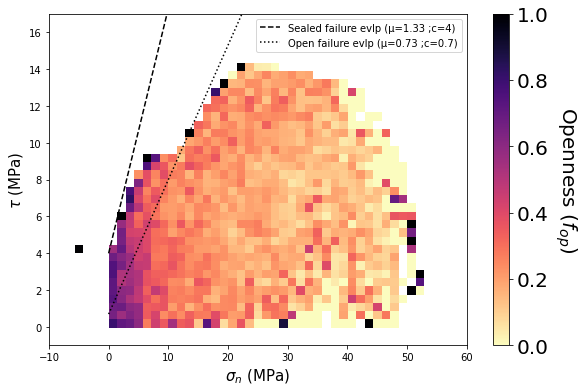

In [15]:
#---plots openness
fig = plt.figure()
ax = plt.subplot(111)
ax.set_xlabel('$\u03C3_n$ (MPa)', fontsize = 15)
ax.set_ylabel('$\u03C4$ (MPa)', fontsize = 15)

pc = ax.pcolorfast(norm_stress_bin, tan_stress_bin, h.T, cmap=plt.cm.magma_r)
colorbar = fig.colorbar(pc)
colorbar.set_label('Openness ($f_{op})$', rotation = 270, fontsize = 20, labelpad=30)
colorbar.ax.tick_params(labelsize=20)

#---plot failure envelops
x = np.linspace(0,60,1000)
y_s = x*_mu_s+_c_s
y_o = x*_mu_o+_c_o

ax.plot(x,y_s, 'k--', label = 'Sealed failure evlp (\u03BC='+str(_mu_s)+' ;c='+str(_c_s)+')')
ax.plot(x,y_o, 'k:', label = 'Open failure evlp (\u03BC='+str(_mu_o)+' ;c='+str(_c_o)+')')

ax.set_xlim(-10,60)
ax.set_ylim(-1,17)
ax.legend(fontsize = 10)

fig.set_tight_layout(True)
fig.set_size_inches(600./fig.dpi,400./fig.dpi)
plt.show()